# Monte Carlo IID Bootstrap for Strategy Returns
Quick bootstrap to get an empirical distribution of outcomes using IID resampling of historical returns.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_palette('husl')

RETURNS_FILE = "walkforward_oos_returns.csv"  # date, return (headerless)
PERIODS_PER_YEAR = 365.25  # adjust if using non-daily data
N_SIM = 10000
SEED = 42

In [9]:
# Load returns
returns_path = Path(RETURNS_FILE)
if not returns_path.exists():
    raise FileNotFoundError(f"Returns file not found: {returns_path}")

ret_df = pd.read_csv(returns_path, header=None, names=['date', 'ret'])
ret_df['date'] = pd.to_datetime(ret_df['date'], errors='coerce')
ret_df['ret'] = pd.to_numeric(ret_df['ret'], errors='coerce')
ret_df = ret_df.dropna(subset=['ret']).reset_index(drop=True)

returns = ret_df['ret'].to_numpy()
path_length = len(returns)
print(f"Loaded {path_length} returns; date range: {ret_df['date'].min().date()} -> {ret_df['date'].max().date()}")

Loaded 809 returns; date range: 2023-09-01 -> 2025-11-17


In [10]:
# Metrics helper

def compute_metrics(ret_series: np.ndarray, periods_per_year: float = PERIODS_PER_YEAR):
    eq = np.cumprod(1 + ret_series)
    final_equity = eq[-1]
    total_return = final_equity - 1
    running_max = np.maximum.accumulate(eq)
    drawdown = (eq - running_max) / running_max
    max_dd = drawdown.min() if drawdown.size else np.nan

    mean = ret_series.mean() if ret_series.size else np.nan
    std = ret_series.std(ddof=1) if ret_series.size > 1 else np.nan
    sharpe = (mean / std * np.sqrt(periods_per_year)) if std and std > 0 else np.nan

    cagr = (final_equity ** (periods_per_year / ret_series.size) - 1) if ret_series.size else np.nan
    return {
        'final_equity': final_equity,
        'total_return': total_return,
        'max_drawdown': max_dd,
        'sharpe': sharpe,
        'cagr': cagr,
    }

In [11]:

# IID bootstrap
rng = np.random.default_rng()  # no seed for true randomness
metrics = []
simulated_returns = []
eq_paths = []
for i in range(N_SIM):
    sample = rng.choice(returns, size=path_length, replace=True)
    metrics.append(compute_metrics(sample))
    simulated_returns.extend(sample.tolist())
    eq_paths.append(np.cumprod(1 + sample))

metrics_df = pd.DataFrame(metrics)
sim_returns_series = pd.Series(simulated_returns, name='sim_return')
eq_paths_array = np.vstack(eq_paths) if eq_paths else np.empty((0, path_length))
eq_mean_path = eq_paths_array.mean(axis=0) if eq_paths_array.size else np.array([])
summary = metrics_df.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T
print("Bootstrap summary (key percentiles):")
print(summary[['mean', 'std', '1%', '5%', '25%', '50%', '75%', '95%', '99%']])


Bootstrap summary (key percentiles):
                  mean       std        1%        5%       25%       50%  \
final_equity  5.881718  4.419702  1.063589  1.622542  3.048417  4.654141   
total_return  4.881718  4.419702  0.063589  0.622542  2.048417  3.654141   
max_drawdown -0.316660  0.085802 -0.564087 -0.478639 -0.366382 -0.304135   
sharpe        1.774587  0.635074  0.277552  0.722989  1.356702  1.777025   
cagr          1.107024  0.646246  0.028225  0.244228  0.654061  1.002250   

                   75%        95%        99%  
final_equity  7.326016  14.188006  22.968333  
total_return  6.326016  13.188006  21.968333  
max_drawdown -0.253403  -0.199271  -0.171478  
sharpe        2.203010   2.814309   3.236912  
cagr          1.457386   2.311870   3.116492  


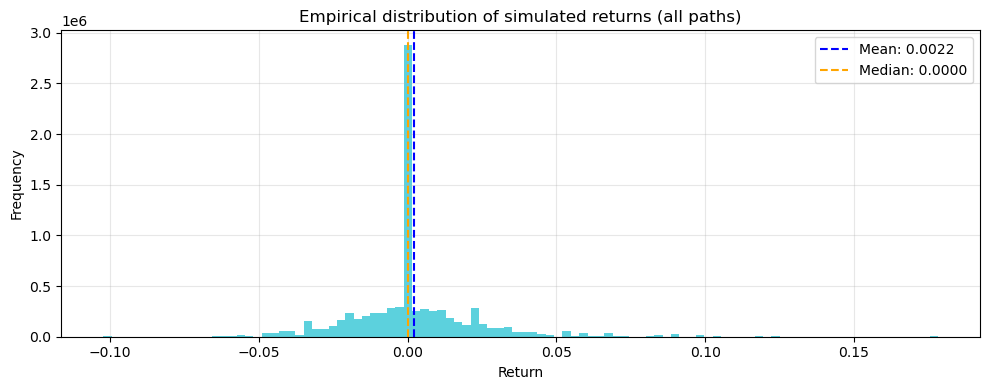

In [12]:

# Empirical distribution of simulated returns
if not sim_returns_series.empty:
    fig, ax = plt.subplots(figsize=(10,4))
    data = sim_returns_series.dropna()
    ax.hist(data, bins=100, color='tab:cyan', alpha=0.7)
    mean_val = data.mean()
    med_val = data.median()
    ax.axvline(mean_val, color='blue', linestyle='--', linewidth=1.5, label=f'Mean: {mean_val:.4f}')
    ax.axvline(med_val, color='orange', linestyle='--', linewidth=1.5, label=f'Median: {med_val:.4f}')
    ax.legend()
    ax.set_title('Empirical distribution of simulated returns (all paths)')
    ax.set_xlabel('Return')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()
else:
    print('No simulated returns to plot.')


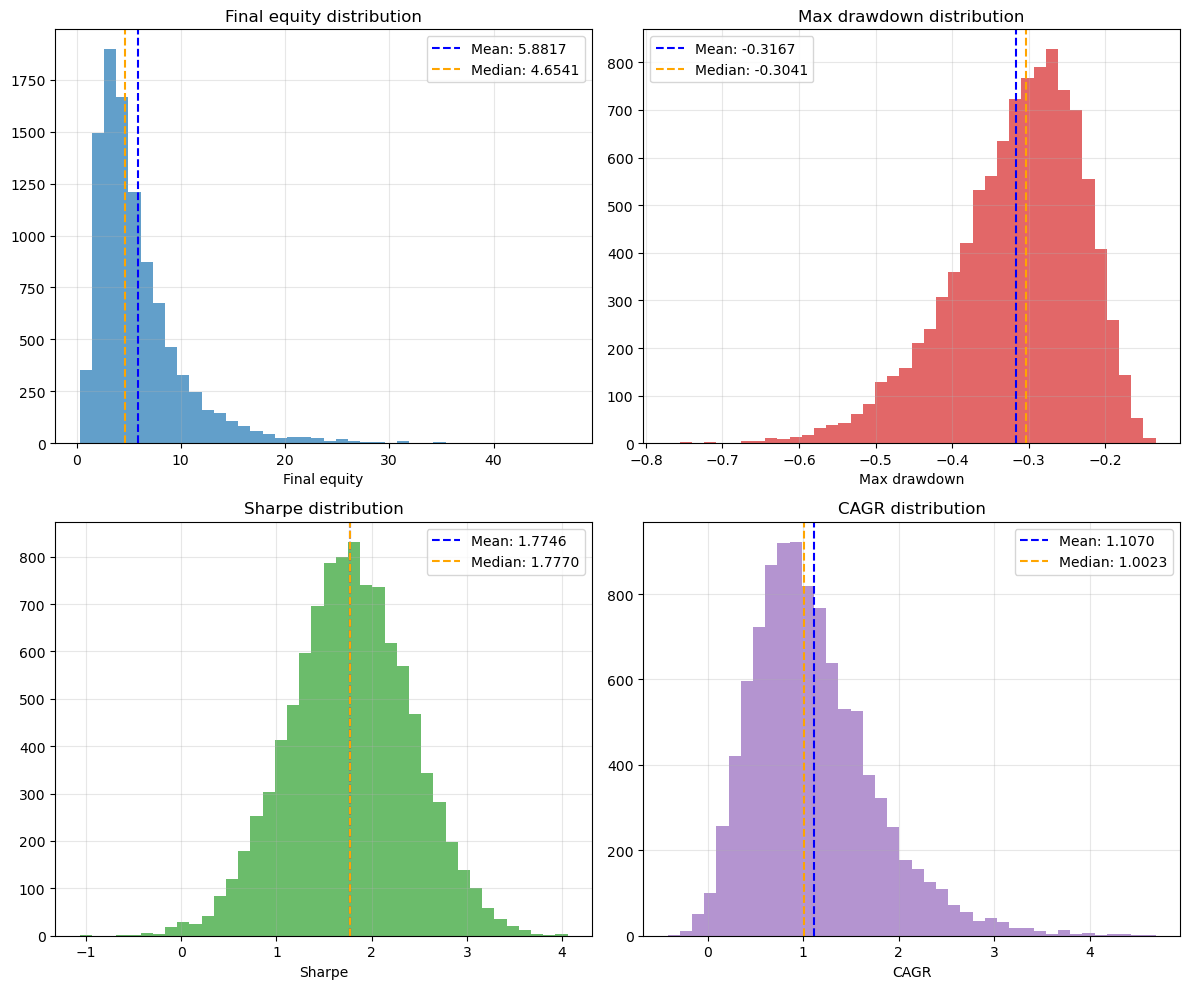

In [13]:

# Plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

plots = [
    ('final_equity', 'Final equity distribution', 'Final equity', 'tab:blue'),
    ('max_drawdown', 'Max drawdown distribution', 'Max drawdown', 'tab:red'),
    ('sharpe', 'Sharpe distribution', 'Sharpe', 'tab:green'),
    ('cagr', 'CAGR distribution', 'CAGR', 'tab:purple'),
]

for ax, (col, title, xlabel, color) in zip(axes, plots):
    data = metrics_df[col].dropna()
    ax.hist(data, bins=40, color=color, alpha=0.7)
    if not data.empty:
        mean_val = data.mean()
        med_val = data.median()
        ax.axvline(mean_val, color='blue', linestyle='--', linewidth=1.5, label=f'Mean: {mean_val:.4f}')
        ax.axvline(med_val, color='orange', linestyle='--', linewidth=1.5, label=f'Median: {med_val:.4f}')
        ax.legend()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


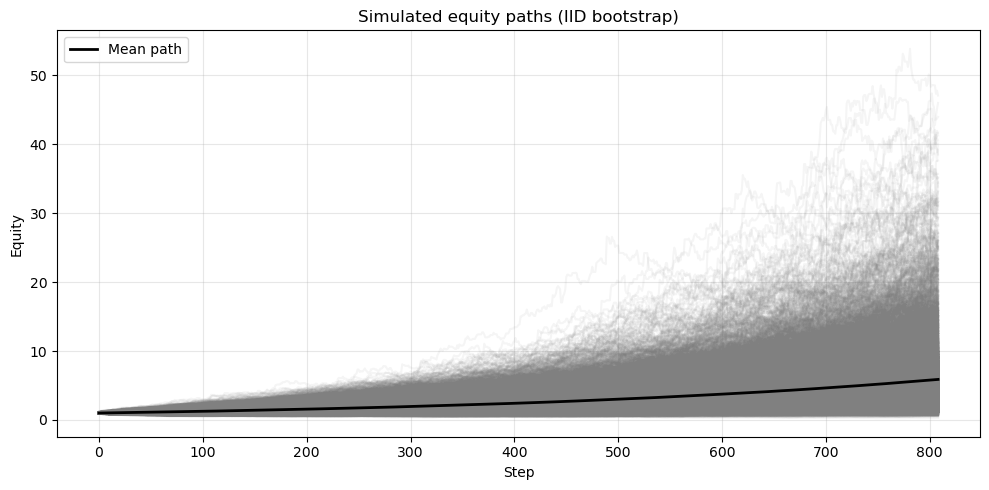

In [14]:

# All simulated equity paths with mean highlighted
if eq_paths_array.size:
    fig, ax = plt.subplots(figsize=(10,5))
    for path in eq_paths_array:
        ax.plot(np.arange(len(path)), path, color='gray', alpha=0.08)
    ax.plot(np.arange(len(eq_mean_path)), eq_mean_path, color='black', linewidth=2.0, label='Mean path')
    ax.set_title('Simulated equity paths (IID bootstrap)')
    ax.set_xlabel('Step')
    ax.set_ylabel('Equity')
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout(); plt.show()
else:
    print('No equity paths recorded (eq_paths_array empty).')


In [15]:
print(eq_mean_path[-1])

5.881717956785151
